In [6]:
from IPython.display import HTML # type: ignore
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import more_itertools
import networkx as nx
import numpy as np
import numpy.linalg as la
from numpy.typing import NDArray
from tqdm.notebook import tqdm
import pandas as pd


import d3networkx as d3nx
from d3networkx.d3graph import D3DiGraph

from dcns.close_edges import get_close_edges
from dcns.graph_utils import node_attr_list_to_ndarray
from dcns.powerlaw import calc_powerlaw_multi

In [2]:
G = D3DiGraph(nx.read_gml("data/dart_stops.gml"))
# Unpack node pos from list to numpy array
node_attr_list_to_ndarray(G, "pos")
# G = D3DiGraph(nx.path_graph(5, create_using=nx.DiGraph))

# Graph styles
style = {"node_size": 5}
# d3.clear()
# d3.set_graph(G)
# d3.update
# d3.set_interactive(True)

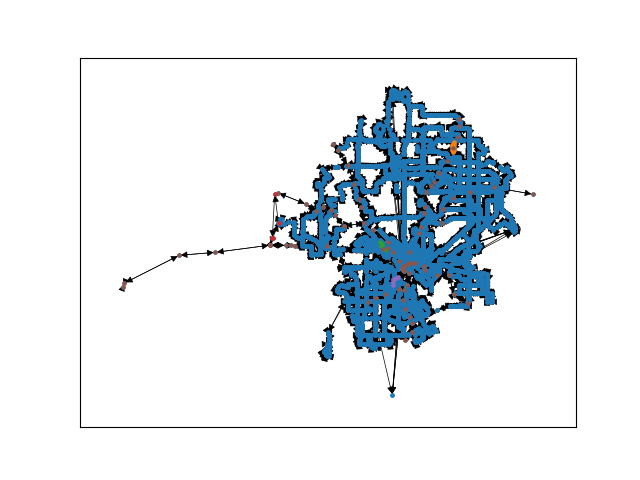

In [3]:
%matplotlib widget
pos = nx.get_node_attributes(G, "pos")

comps = list(nx.weakly_connected_components(G))

# Plot each weakly-connected component in its own color
nx.draw_networkx(G, pos=pos, node_size=5, width=0.5, with_labels=False)
colors = plt.get_cmap('tab10').colors # type: ignore

for component, color in zip(comps, colors):
    nx.draw_networkx(
        G.subgraph(component),
        pos=pos,
        node_color=[color],
        node_size=5,
        width=0.5,
        with_labels=False,
    )

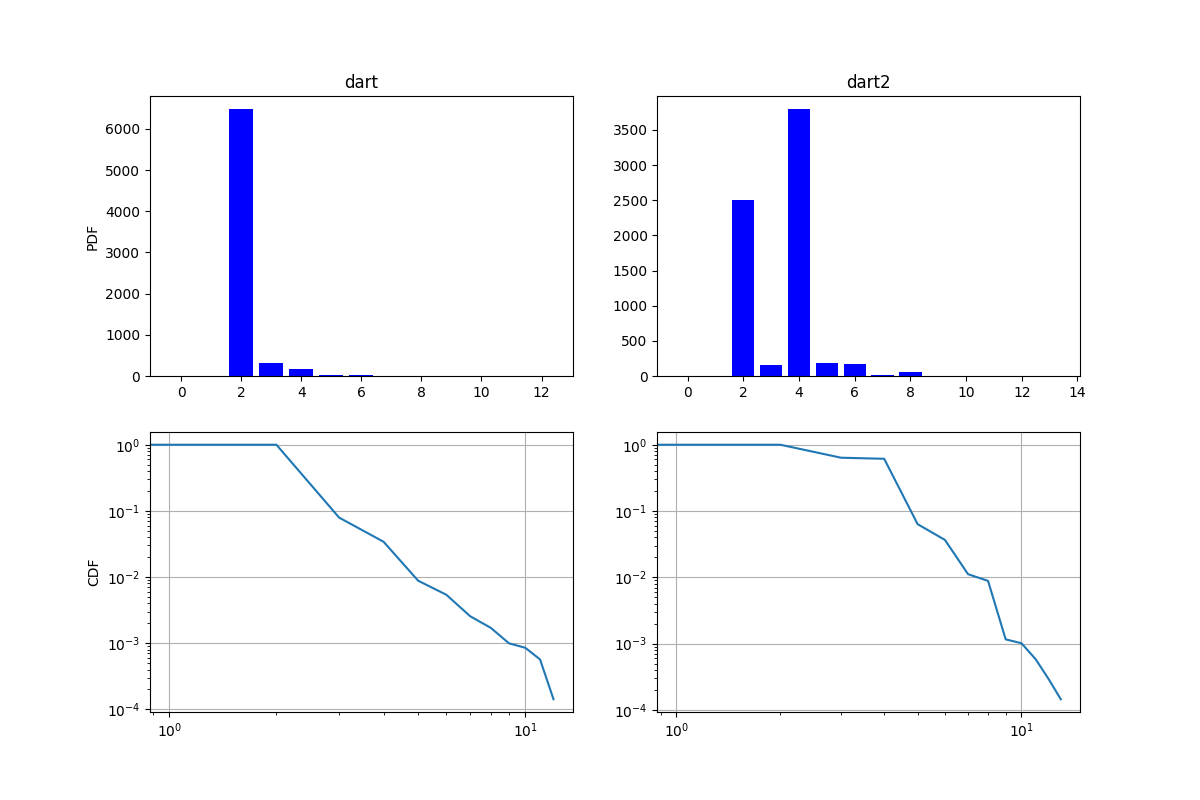

In [22]:
calc_powerlaw_multi({"dart": G, "dart2": G2})
plt.show()

In [22]:
# Reload powerlaw (if necessary)
# del calc_powerlaw_multi
import dcns.pathfinding
import importlib
importlib.reload(dcns.pathfinding)

<module 'dcns.pathfinding' from 'c:\\Users\\Andrew\\Code\\dcns-project\\dcns\\pathfinding.py'>

In [3]:
G2 = G.__class__(G.subgraph(max(nx.strongly_connected_components(G), key=len)))
# nx.set_edge_attributes(G2, nx.get_edge_attributes(G2, "num_trips"), "weight") 

In [99]:
len(pathfind_steps(astar_search(G2, "30141", "31212"), "30141", "31212")[1])

2

In [23]:
from dcns.pathfinding import (
    dijkstra,
    astar,
    astar_search,
    pathfind_steps,
    astar_dist_search,
    astar_dist,
)


goals = [
    ("30141", "31212"),
    ("30140", "31212"),
    ("16516", "31212"),
    ("20527", "29291"),
    ("33302", "30496"),
    ("33286", "16971"),
]
# 30141 & 30140

start = goals[0][0]
end = goals[0][1]

len(astar(G2, start, end)[0])

117

In [5]:
from functools import partial
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def plot_graph(graph, pos, ax, min_edge_length=0.007, style=None):
    if style is None:
        style = {}
    # Only draw edges over a threshold for faster displaying
    edges = [
        (u, v)
        for u, v in graph.edges()
        if np.linalg.norm(pos[u] - pos[v]) > min_edge_length
    ]
    nx.draw_networkx_edges(
        graph,
        pos=pos,
        ax=ax,
        edgelist=edges,
        alpha=0.4,
        width=0.5,
        **style,
    )
    nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color="tab:blue", **style)
    ax.set_aspect("equal")


def plot_pathfinding(
    graph,
    search_func,
    start,
    end,
    min_edge_length=0.007,
):
    pos = nx.get_node_attributes(graph, "pos")

    steps = pathfind_steps(
        search_func(graph, start, end),
        start,
        end,
        sample_steps=(200, 10),
    )
    steps.insert(0, steps[0])  # Artificially extend the length of the first frame

    fig, ax = plt.subplots()

    def update(frame: int):
        if frame >= len(steps):
            return

        searched_nodes, path_nodes = steps[frame]

        # Draw the updated graph with new node colors
        nx.draw_networkx_nodes(
            graph,
            pos=pos,
            ax=ax,
            nodelist=searched_nodes,
            node_color="tab:orange",
            **style,
        )
        nx.draw_networkx_nodes(
            graph,
            pos=pos,
            ax=ax,
            nodelist=path_nodes,
            node_color="tab:green",
            **style,
        )

    # Create an animation object
    return FuncAnimation(
        fig,
        update,
        init_func=partial(
            plot_graph, graph, pos, ax, min_edge_length=min_edge_length, style=style
        ),
        interval=100,
        frames=len(steps) + 3,
        repeat=True,
    )



In [18]:
pos = nx.get_node_attributes(G2, "pos")
for start, end in goals:
    p, d, s = astar(G2, start, end, lambda u, v: np.linalg.norm(pos[u]-pos[v]))
    print(len(p), d, s)
print()

for start, end in goals:
    p, d, s = astar_dist(G3, start, end, nx.get_node_attributes(G3, "pos"))
    print(len(p), d, s)

117 5244.559999999999 3891
78 4948.490000000001 4237
62 3306.6200000000003 3176
74 3983.8099999999995 1530
81 6841.490000000001 3672
77 3255.6800000000003 3066

71 4531.08 3381
32 4235.01 3562
16 2593.1400000000003 1516
32 3057.99 1020
81 6841.490000000001 4090
75 3572.879999999999 4019


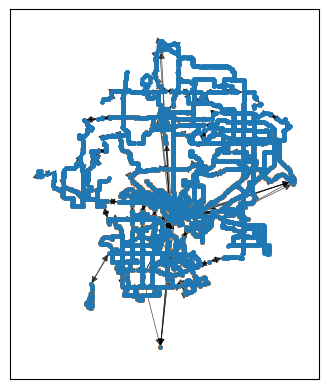

In [8]:
anim = plot_pathfinding(
    G2,
    astar_dist_search,
    goals[0][0],
    goals[0][1],
    min_edge_length=0.007,
)

# Note: for this to work, you must have ImageMagick installed on your computer AND you
# must set to the path to `convert.exe` (ImageMagick < 7.x) or `magick.exe` for
# (ImageMagick >= 7.x) in the `matplotlibrc` file.
#
# animation.convert_path: C:\Program Files\ImageMagick-7.1.1-Q16-HDRI\magick.exe
#
# See: https://matplotlib.org/stable/tutorials/introductory/customizing.html
anim.save("./images/astar_dist.gif", writer="imagemagick", fps=10)

In [117]:
HTML(anim.to_jshtml())

In [17]:
G3 = G2.__class__(G2)
close_edges = get_close_edges(nx.get_node_attributes(G3, "pos"), 0.0005, 50)
# Add 2-way edges for crossing the street
weight=1000
G3.add_weighted_edges_from(ebunch_to_add={(u, v, weight) for u, v in close_edges})
G3.add_weighted_edges_from(ebunch_to_add={(v, u, weight) for u, v in close_edges})

100%|██████████| 2500/2500 [00:07<00:00, 333.52it/s]


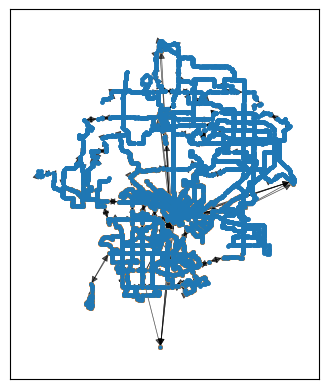

: 

In [121]:
anim2 = plot_pathfinding(
    G3,
    astar_dist_search,
    goals[0][0],
    goals[0][1],
    min_edge_length=0.007,
)
HTML(anim2.to_jshtml())

In [94]:
%matplotlib widget
nx.draw(G2, pos=pos, node_size=5, width=0.5, with_labels=False)

In [ ]:
def graph_diffusion(G: D3Graph, c: float, x0: float, delay=0):
    # L = D - A
    L = nx.laplacian_matrix(G).toarray().T
    N = G.number_of_nodes()

    x = np.zeros(N)
    x[0] = x0

    # Equilibrium state
    min_eigvec = get_min_eigenvector(L)
    x_equilibrium = min_eigvec / min_eigvec[0] * la.norm(x) / N
    # x_equilibrium = np.ones(N) * la.norm(x) / N

    x_dist = np.zeros(time.shape[0])

    # at each time step update the value of x!
    for i, t in enumerate(time):
        # Distance is the magnitude of the difference of states.
        x_dist[i] = la.norm(x - x_equilibrium)

        # dx/dt = -cLx
        x += c * -L @ x * dt

        yield x

    return x_dist

def update_diffusion(frame: int, ):
    ...

anim_diffusion = FuncAnimation(
    fig,
    update,
    init_func=partial(
        plot_graph, graph, pos, ax, min_edge_length=min_edge_length
    ),
    interval=100,
    frames=len(steps) + 3,
    repeat=True,
)

In [8]:
v = nx.katz_centrality(G2)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('20431', 0.023891383133855137),
 ('33245', 0.01823958651197319),
 ('33221', 0.018066613885416992),
 ('33229', 0.017947073911942703),
 ('33286', 0.017170152312094938)]

In [12]:
v = nx.eigenvector_centrality(G)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('28264', 0.5368265196350608),
 ('22749', 0.4591515527756928),
 ('22748', 0.45889848812278444),
 ('28172', 0.2501210784473024),
 ('29825', 0.24689415583573063)]

In [11]:
nx.diameter(G2)
# Diameter = 356

356

In [21]:
nx.is_tree(G2)

False